# Load Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import fiona
import pyproj
import contextily
import plotly.express as px
import gc
import seaborn
import statistics
import statsmodels.api as sm
import pylab as py
import math

from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed
from splot.esda import plot_moran
from splot import esda as esdaplot
from IPython.display import display, Markdown, display_latex, display_markdown, display_html
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
#path = "/srv/data/my_shared_data_folder/cpr/"

#dir_list = os.listdir(path)
#dir_in = os.listdir(os.getcwd())
#directory = pd.Series(dir_in)
#print(dir_in)
#print(dir_list)

/opt/tljh/user/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/opt/tljh/user/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/opt/tljh/user/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:199: N

# Functions

In [2]:
#function that automates autocorrelation for pounds of pesticide applied
def autocorr(df):
    # Calculating the mean and standard deviation
    meanv = statistics.mean(df['POUNDS_PRODUCT_APPLIED'].dropna())
    stdev = statistics.stdev(df['POUNDS_PRODUCT_APPLIED'].dropna())

    # Droping records that are more than 1 standard deviation from the mean
    filtered_df = df[df['POUNDS_PRODUCT_APPLIED'] < meanv+(2*stdev)]
    filtered_df.reset_index(inplace=True)
    
    # Generate W from the GeoDataFrame
    # Need to convert this to polygon data
    w = weights.KNN.from_dataframe(filtered_df)
    # Row-standardization
    w.transform = 'R'
    
    # Calculate the spatial lag
    filtered_df['POUNDS_PRODUCT_APPLIED_lag'] = weights.spatial_lag.lag_spatial(
    w, filtered_df['POUNDS_PRODUCT_APPLIED'])

    # Standardize the variable of interest and the lag variable
    filtered_df['POUNDS_PRODUCT_APPLIED_std'] = (filtered_df['POUNDS_PRODUCT_APPLIED'] - filtered_df['POUNDS_PRODUCT_APPLIED'].mean())
    filtered_df['POUNDS_PRODUCT_APPLIED_lag_std'] = (filtered_df['POUNDS_PRODUCT_APPLIED_lag'] - filtered_df['POUNDS_PRODUCT_APPLIED_lag'].mean())
    
    #initialize empty vector to save plots
    plot_list = []
    
    #Morans plot
    morans_plot, ax = plt.subplots(1, figsize=(10, 10))
    seaborn.regplot(
    x='POUNDS_PRODUCT_APPLIED_std', # variable of interest
    y='POUNDS_PRODUCT_APPLIED_lag_std', # spatial lag
    ci=None, # suppress the plotting of the confidence interval
    data=filtered_df, # dataset
    line_kws={'color':'r'})

    ax.axvline(0, c='k', alpha=0.8)
    ax.axhline(0, c='k', alpha=0.8)

    ax.set_title('Moran Plot - Total Amount of Pesticide Applied (lbs)')
    ax.set_xlabel('Standardized TPPA')
    ax.set_ylabel('Standardized TPPA Lag')
    plt.show()
    plot_list.append(morans_plot)
    
    morans_stat = esda.moran.Moran(filtered_df['POUNDS_PRODUCT_APPLIED'], w)
    stat1 = morans_stat.I
    stat1_pval = morans_stat.p_sim
    plot2 = plot_moran(morans_stat)
    #display(Markdown(f"""**Morans I:** {morans_stat.I}"""))
    #display(Markdown(f"""**p-value:** {morans_stat.p_sim}"""))
    plot_list.append(stat1)
    plot_list.append(stat1_pval)
    plot_list.append(plot2)
    
    #Local autocorrelation
    price_lisa = esda.moran.Moran_Local(filtered_df['POUNDS_PRODUCT_APPLIED'], w)
    
    # Draw KDE line
    kdeplot, ax = plt.subplots(1, figsize=(10, 10))
    seaborn.kdeplot(price_lisa.Is, ax=ax)
    plt.show()
    #append kdeplot
    plot_list.append(kdeplot)
    
    
    #calculate and plot local lisas
    local_lisas, ax = plt.subplots(1, figsize=(10, 10))
    # Create a new column with the values from the Moran's Local LISAs
    filtered_df.assign(
        ML_Is=price_lisa.Is
    
    # Plot choropleth of local statistics
    ).plot(
        column='ML_Is', 
        cmap='vlag', 
        scheme='quantiles',
        k=4, 
        edgecolor='white', 
        linewidth=0.1, 
        alpha=0.75,
        legend=True,
        ax=ax
    )
    contextily.add_basemap(
    ax,
    crs=filtered_df.crs,
    source=contextily.providers.CartoDB.Positron,
    )

    plt.show()
    #append local lisas plot
    plot_list.append(local_lisas)
    
    
    # Plot a map assigning each observation with its quadrant value HH, HL, LH, LL
    quad_assignments, ax = plt.subplots(1, figsize=(10, 10))
    esdaplot.lisa_cluster(price_lisa, filtered_df, p=1, ax=ax);
    contextily.add_basemap(
    ax,
    crs=filtered_df.crs,
    source=contextily.providers.CartoDB.Positron,
    )
    plt.show()
    #append quad assignments  plot
    plot_list.append(quad_assignments)
    
    
    #plot by significance
    sig, ax = plt.subplots(1, figsize=(10, 10))
    
    # First, we need to find out which observations are significant
    alpha = 0.05
    labels = pd.Series(
        1 * (price_lisa.p_sim < alpha), # 1: Indicates significance at alpha of .05 and 0 indicates insignificant values
        index=filtered_df.index

    # Recoding 1 to be "Significant and 0 to be "Insignificant"
    ).map({1: 'Significant', 0: 'Insignificant'})

    # Creating a new column with the labels for significance called ML_Sig
    filtered_df.assign(
        ML_Sig=labels

    # Ploting a map of the insignificant values
    ).plot(
        column='ML_Sig', 
        categorical=True,
        k=2,
        cmap='vlag',
        linewidth=0.1,
        edgecolor='white',
        legend=True,
        ax=ax
    )
    contextily.add_basemap(
    ax,
    crs=filtered_df.crs,
    source=contextily.providers.CartoDB.Positron,
    )
    #append sig plot
    plot_list.append(sig)
    
    # Plot one final map using the alpha of 0.05
    final, ax = plt.subplots(1, figsize=(10, 10))

    esdaplot.lisa_cluster(price_lisa, filtered_df, p=alpha, ax=ax);
    contextily.add_basemap(
    ax,
    crs=filtered_df.crs,
    source=contextily.providers.CartoDB.Positron,
    )
    plt.show()
    #append final plot
    plot_list.append(final)
    
    return(plot_list)

# Load & clean features dataframe

In [3]:
features = pd.read_csv('data/new_pesticide_data/pesticide_5_w_tracts+.csv', low_memory = False) 
#features

# Subset data for each county

In [4]:
features2 = features.loc[(features['YEAR'] == 2020), ['PU_FIPS', 'POUNDS_PRODUCT_APPLIED']]
features2 = features2.groupby('PU_FIPS')['POUNDS_PRODUCT_APPLIED'].sum().reset_index()

fresno_features = features.loc[(features['COUNTY_NAME'] == 'FRESNO') & (features['YEAR'] == 2020), ['PU_FIPS', 'POUNDS_PRODUCT_APPLIED']]
fresno_features = fresno_features.groupby('PU_FIPS')['POUNDS_PRODUCT_APPLIED'].sum().reset_index()

kern_features = features.loc[(features['COUNTY_NAME'] == 'KERN') & (features['YEAR'] == 2020), ['PU_FIPS', 'POUNDS_PRODUCT_APPLIED']]
kern_features = kern_features.groupby('PU_FIPS')['POUNDS_PRODUCT_APPLIED'].sum().reset_index()
                              
la_features = features.loc[(features['COUNTY_NAME'] == 'LOS ANGELES') & (features['YEAR'] == 2020), ['PU_FIPS', 'POUNDS_PRODUCT_APPLIED']]
la_features = la_features.groupby('PU_FIPS')['POUNDS_PRODUCT_APPLIED'].sum().reset_index()                            
 
mendocino_features = features.loc[(features['COUNTY_NAME'] == 'MENDOCINO') & (features['YEAR'] == 2020), ['PU_FIPS', 'POUNDS_PRODUCT_APPLIED']]
mendocino_features = mendocino_features.groupby('PU_FIPS')['POUNDS_PRODUCT_APPLIED'].sum().reset_index()     

monterey_features = features.loc[(features['COUNTY_NAME'] == 'MONTEREY') & (features['YEAR'] == 2020), ['PU_FIPS', 'POUNDS_PRODUCT_APPLIED']]
monterey_features = monterey_features.groupby('PU_FIPS')['POUNDS_PRODUCT_APPLIED'].sum().reset_index()     

# Load Census/Geometry Data

In [5]:
places = gpd.read_file('data/new_pesticide_data/tracts_w_geo+.geojson')
#places = places[['FIPS GEOID','geometry','pct_hispanic_or_latino']]
#places

# Merge pesticide use data and census data

In [6]:
features2_merged = places.merge(features2,'inner', left_on='FIPS GEOID',right_on='PU_FIPS')
fresno_features_merged = places.merge(fresno_features,'inner', left_on='FIPS GEOID',right_on='PU_FIPS')
kern_features_merged = places.merge(kern_features,'inner', left_on='FIPS GEOID',right_on='PU_FIPS')
la_features_merged = places.merge(la_features,'inner', left_on='FIPS GEOID',right_on='PU_FIPS')
mendocino_features_merged = places.merge(mendocino_features,'inner', left_on='FIPS GEOID',right_on='PU_FIPS')
monterey_features_merged = places.merge(monterey_features,'inner', left_on='FIPS GEOID',right_on='PU_FIPS')

# Group data by Geometry

In [7]:
features2_grouped = features2_merged.groupby('geometry')[['POUNDS_PRODUCT_APPLIED']].sum().reset_index()
features2_grouped = gpd.GeoDataFrame(features2_grouped,geometry=features2_grouped.geometry,crs="ESPG:4326")

features3_grouped = features2_merged.groupby('geometry')[['pct_hispanic_or_latino']].mean().reset_index()
features3_grouped = gpd.GeoDataFrame(features3_grouped,geometry=features3_grouped.geometry,crs="ESPG:4326")

fresno_features_grouped = fresno_features_merged.groupby('geometry')[['POUNDS_PRODUCT_APPLIED']].sum().reset_index()
fresno_features_grouped = gpd.GeoDataFrame(fresno_features_grouped,geometry=fresno_features_grouped.geometry,crs="ESPG:4326")

kern_features_grouped = kern_features_merged.groupby('geometry')[['POUNDS_PRODUCT_APPLIED']].sum().reset_index()
kern_features_grouped = gpd.GeoDataFrame(kern_features_grouped,geometry=kern_features_grouped.geometry,crs="ESPG:4326")

la_features_grouped = la_features_merged.groupby('geometry')[['POUNDS_PRODUCT_APPLIED']].sum().reset_index()
la_features_grouped = gpd.GeoDataFrame(la_features_grouped,geometry=la_features_grouped.geometry,crs="ESPG:4326")

mendocino_features_grouped = mendocino_features_merged.groupby('geometry')[['POUNDS_PRODUCT_APPLIED']].sum().reset_index()
mendocino_features_grouped = gpd.GeoDataFrame(mendocino_features_grouped,geometry=mendocino_features_grouped.geometry,crs="ESPG:4326")

monterey_features_grouped = monterey_features_merged.groupby('geometry')[['POUNDS_PRODUCT_APPLIED']].sum().reset_index()
monterey_features_grouped = gpd.GeoDataFrame(monterey_features_grouped,geometry=monterey_features_grouped.geometry,crs="ESPG:4326")

# Spatial Autocorrelation

/opt/tljh/user/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 15 disconnected components.
  warnings.warn(message)
/opt/tljh/user/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/tljh/user/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/tljh

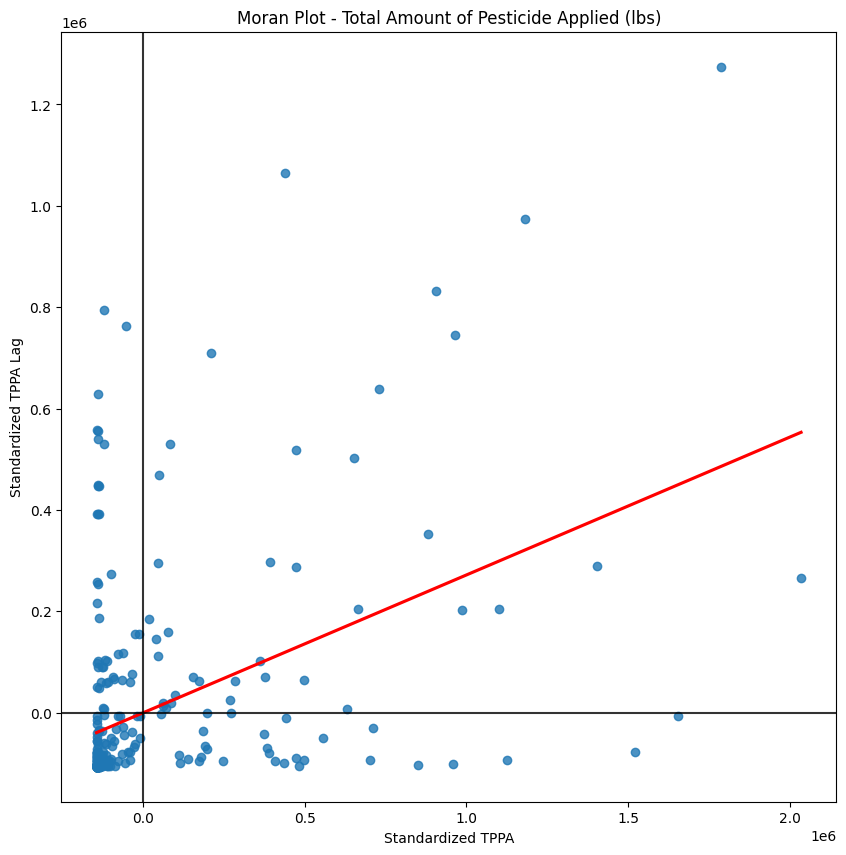

/opt/tljh/user/lib/python3.9/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


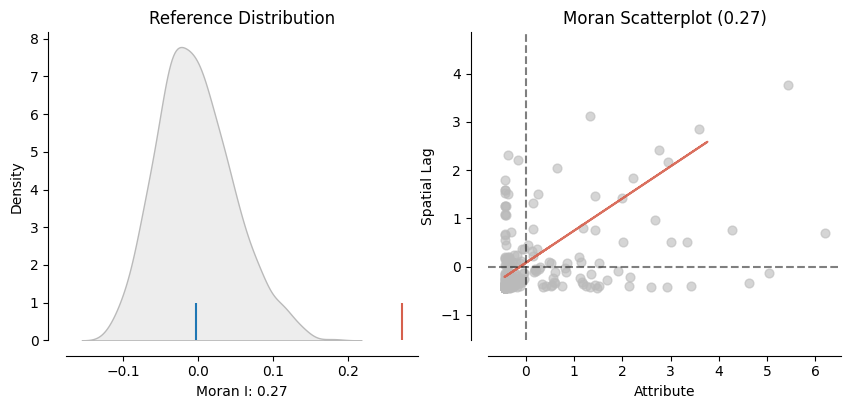

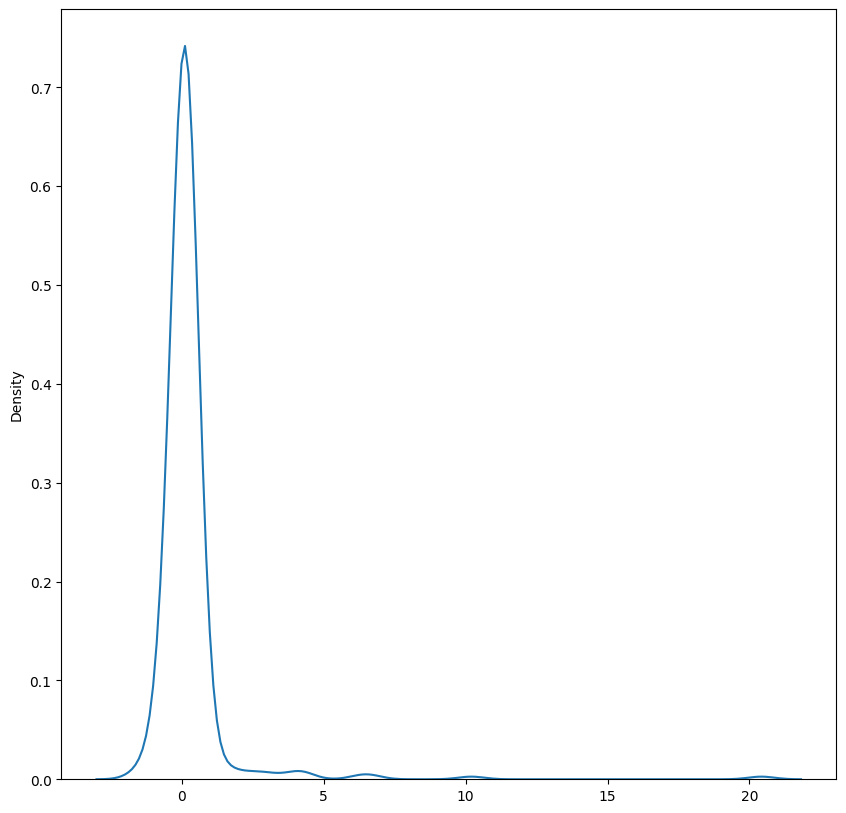

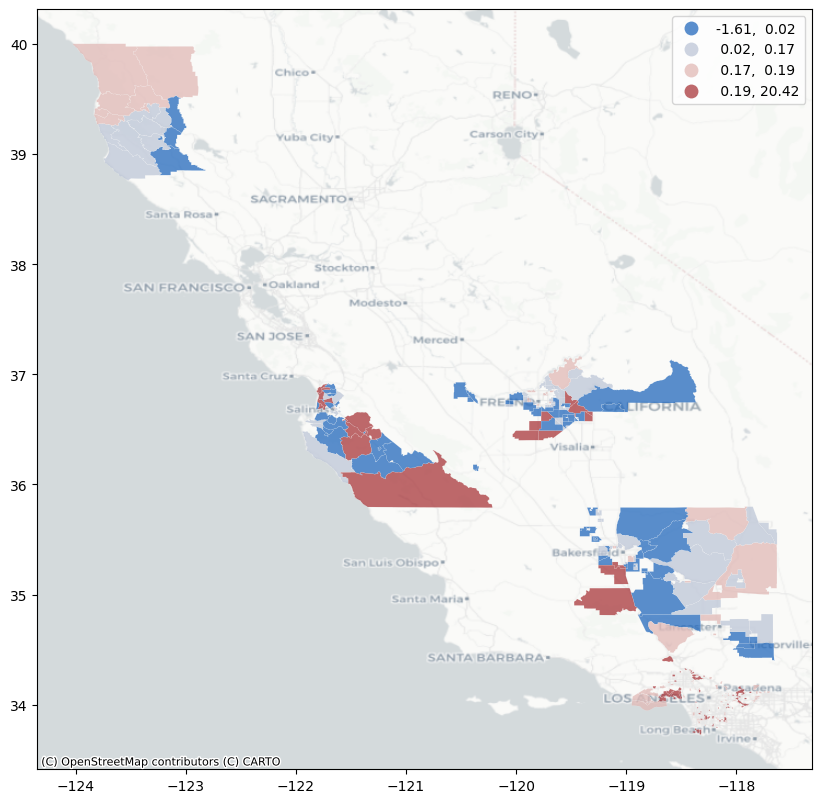

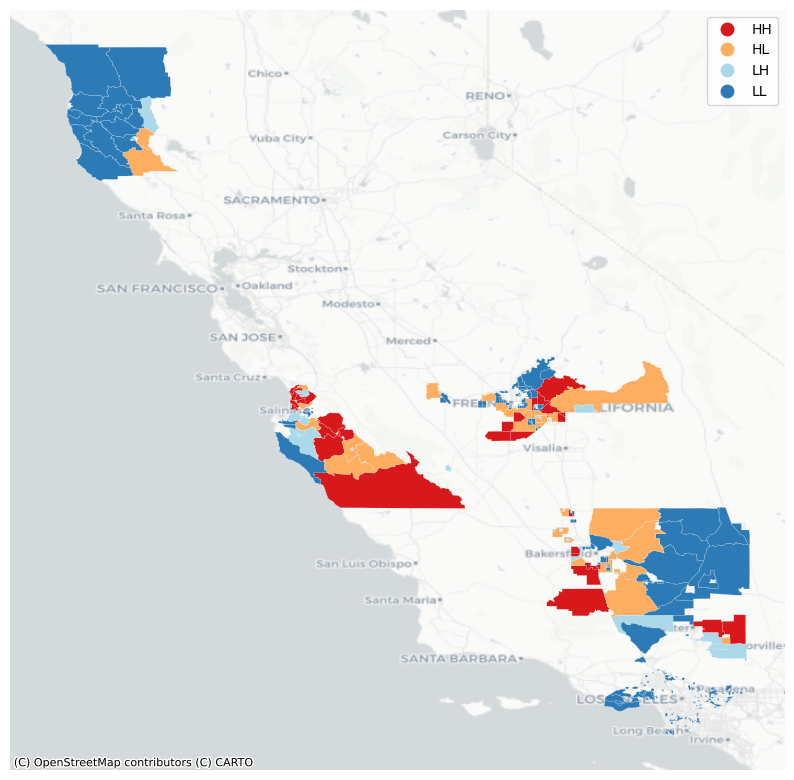

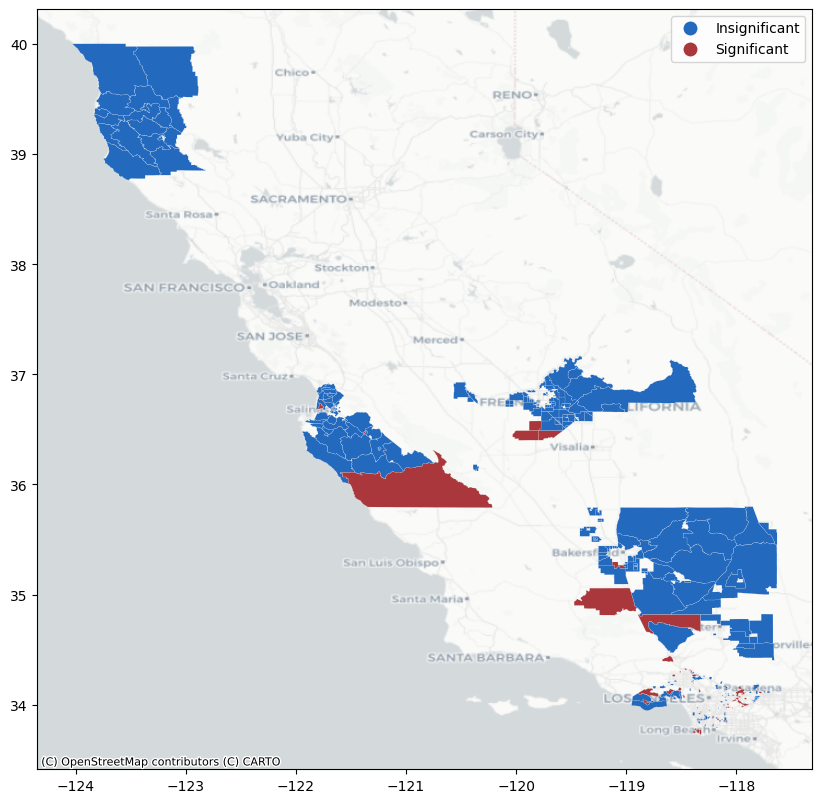

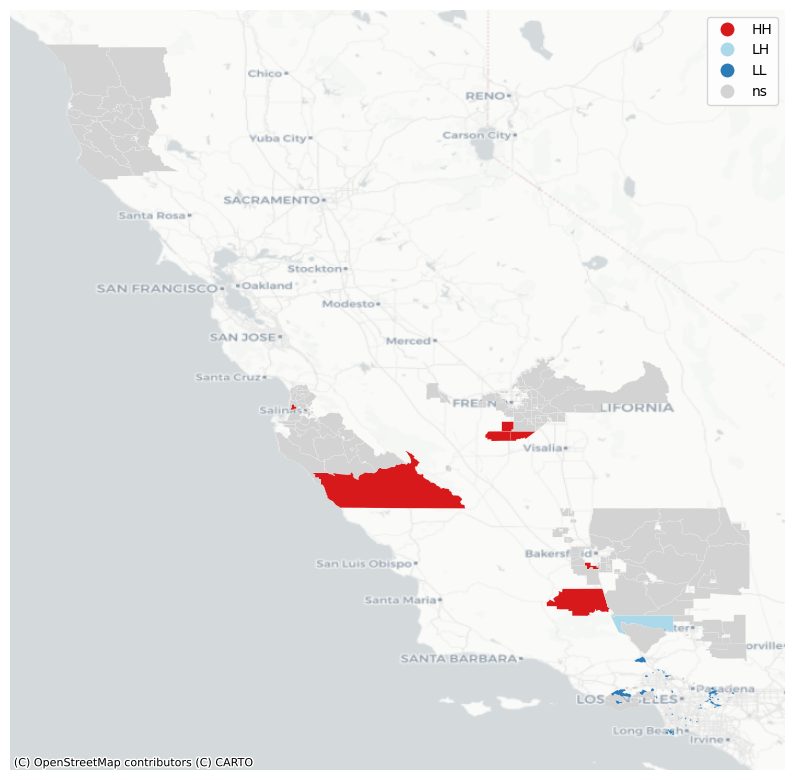

[<Figure size 1000x1000 with 1 Axes>,
 0.2718926498672475,
 0.001,
 (<Figure size 1000x400 with 2 Axes>,
  array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.27', ylabel='Density'>,
         <Axes: title={'center': 'Moran Scatterplot (0.27)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
        dtype=object)),
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>]

In [8]:
#spatial autocorrelation for all 5 counties
allfeatures_acstats = autocorr(features2_grouped)
allfeatures_acstats

/opt/tljh/user/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  warnings.warn(message)
/opt/tljh/user/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/tljh/user/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/tljh/

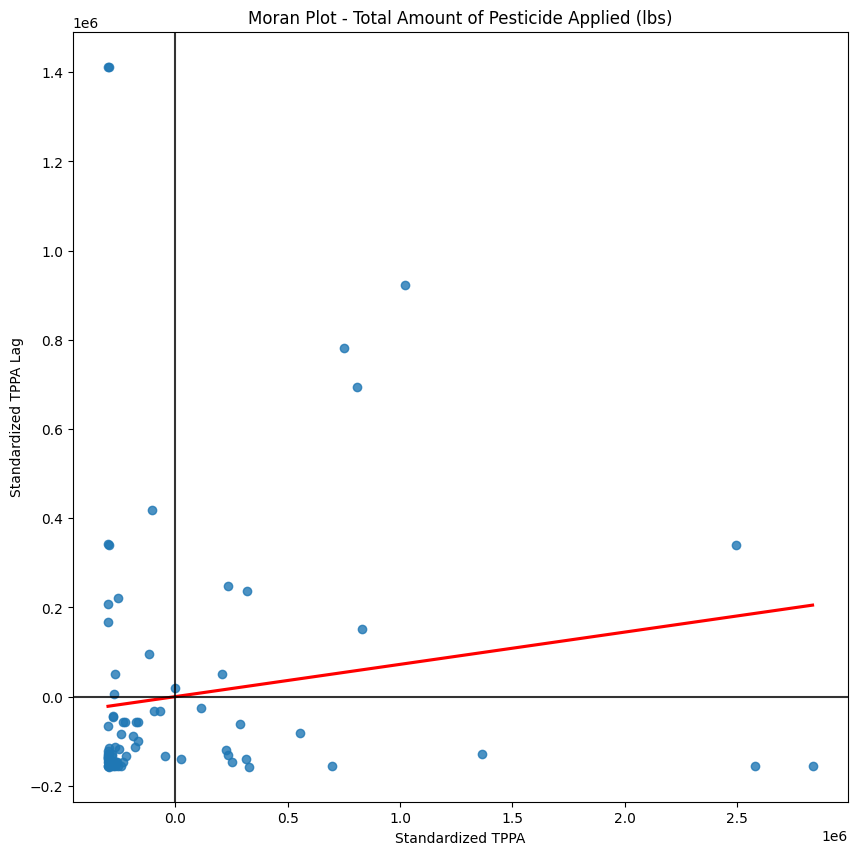

/opt/tljh/user/lib/python3.9/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


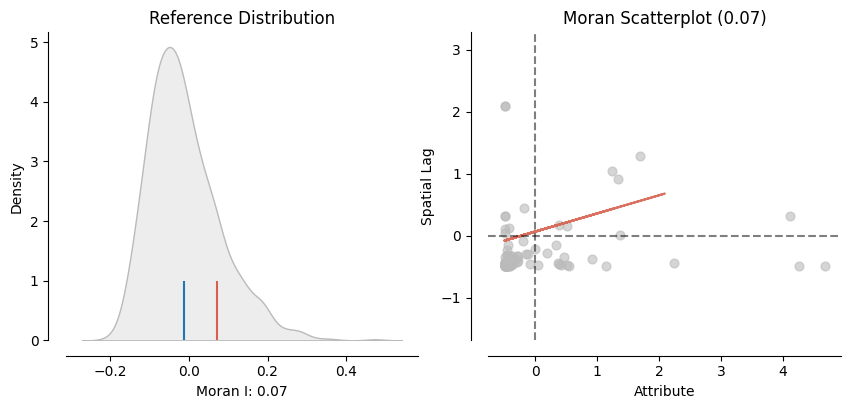

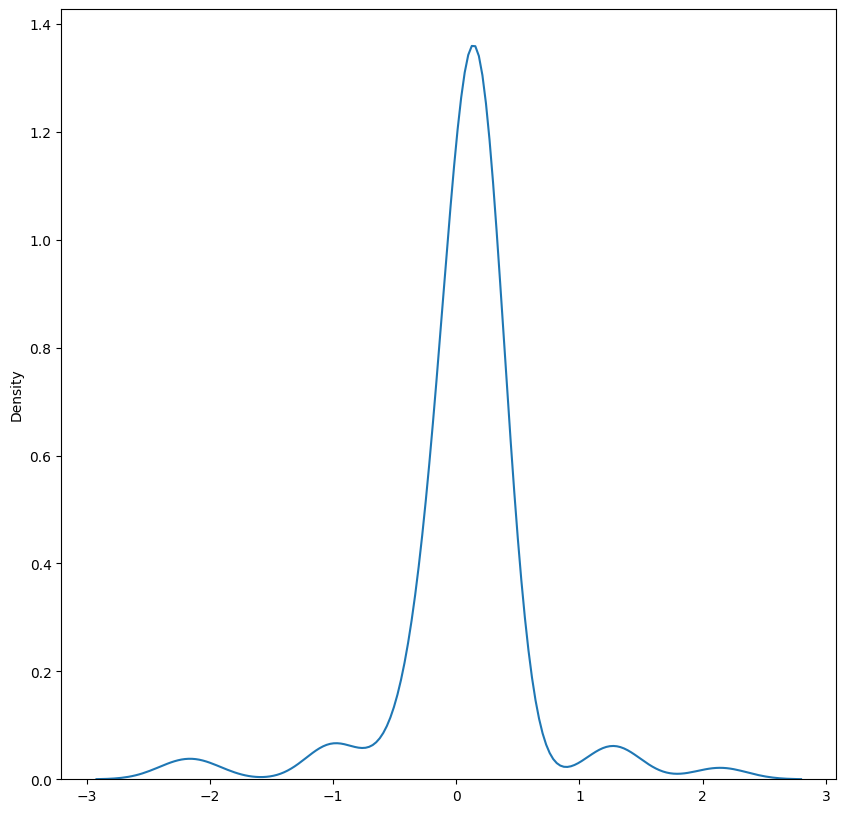

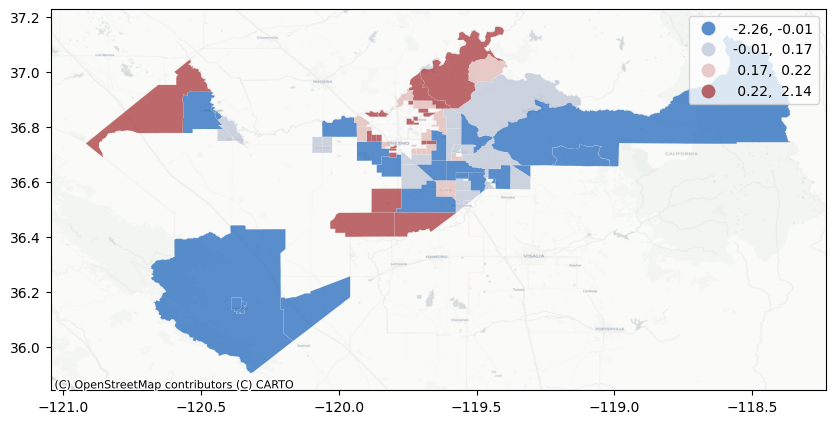

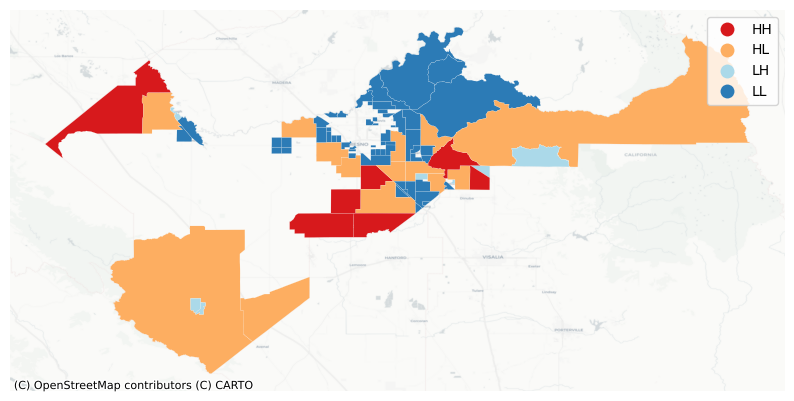

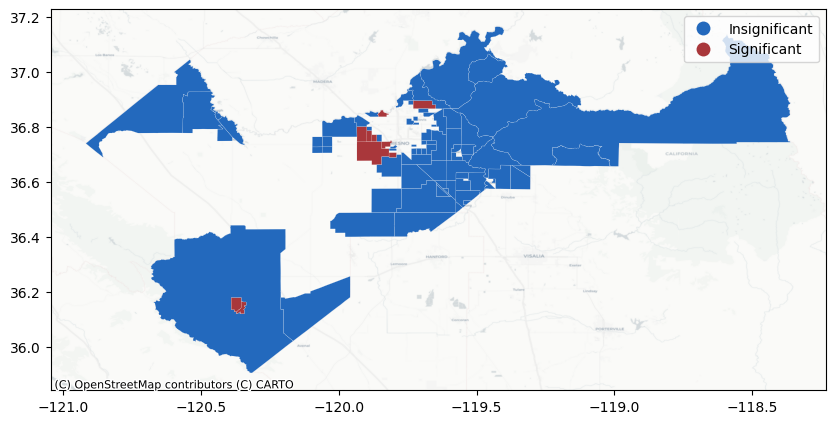

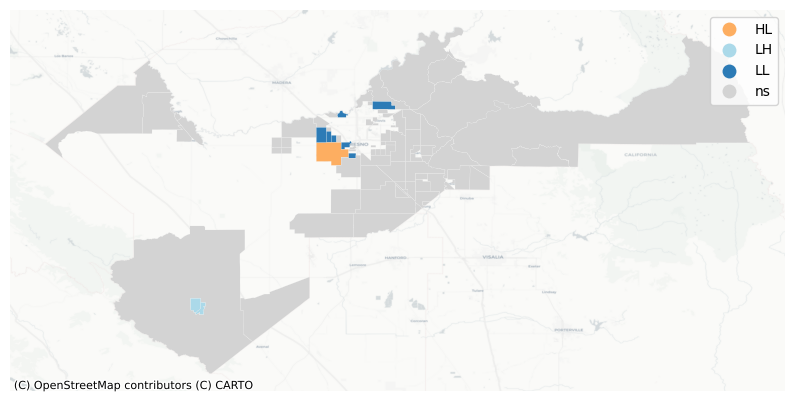

[<Figure size 1000x1000 with 1 Axes>,
 0.07232084214212414,
 0.166,
 (<Figure size 1000x400 with 2 Axes>,
  array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.07', ylabel='Density'>,
         <Axes: title={'center': 'Moran Scatterplot (0.07)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
        dtype=object)),
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>]

In [9]:
#spatial autocorrelation for Fresno
fresno_acstats = autocorr(fresno_features_grouped)
fresno_acstats

/opt/tljh/user/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)
/opt/tljh/user/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/tljh/user/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/tljh/

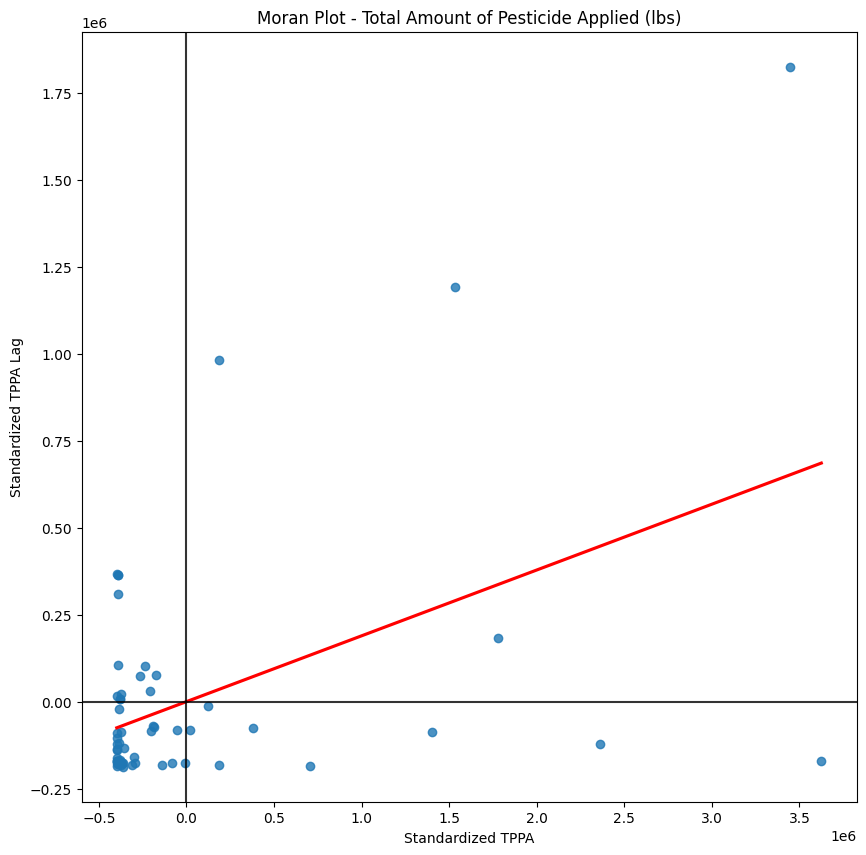

/opt/tljh/user/lib/python3.9/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


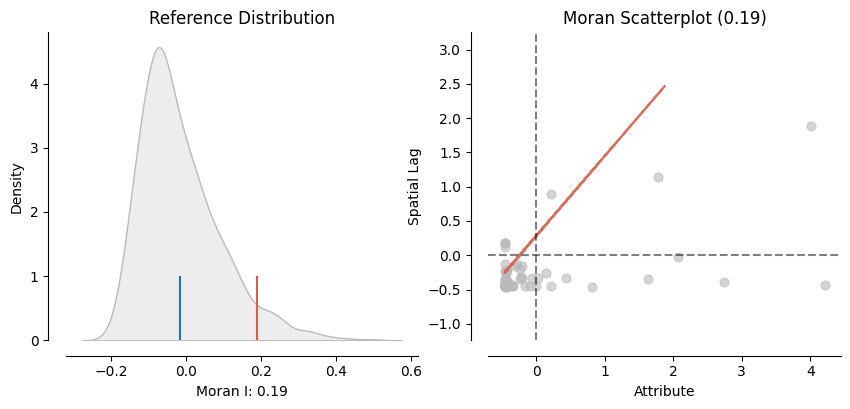

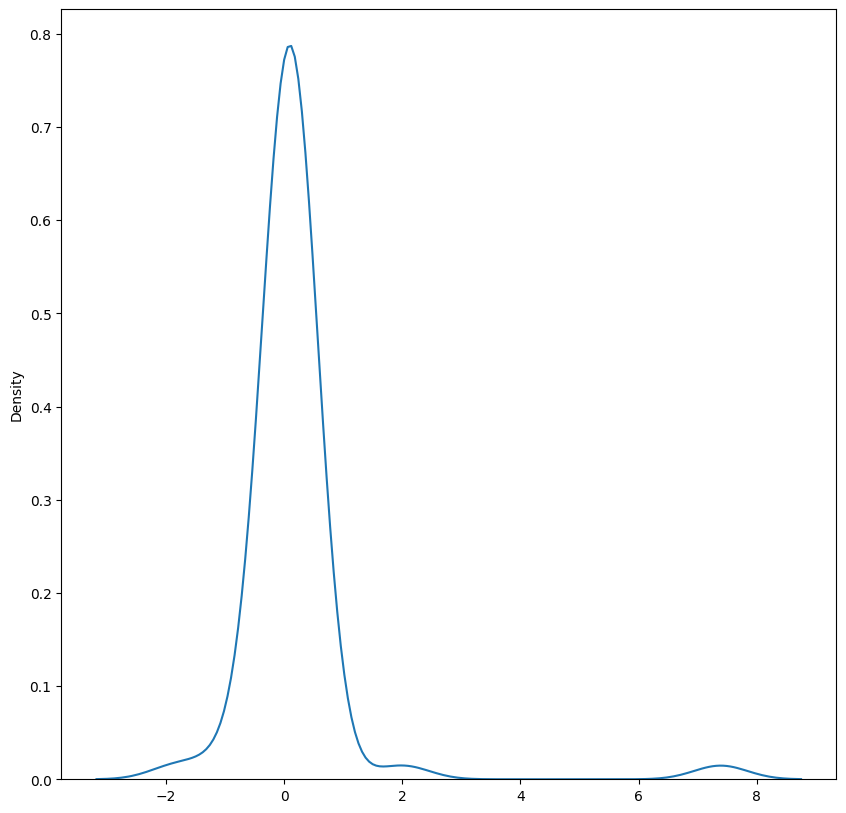

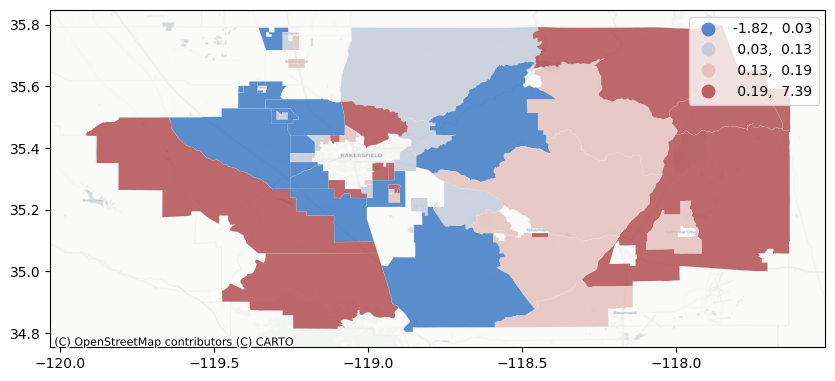

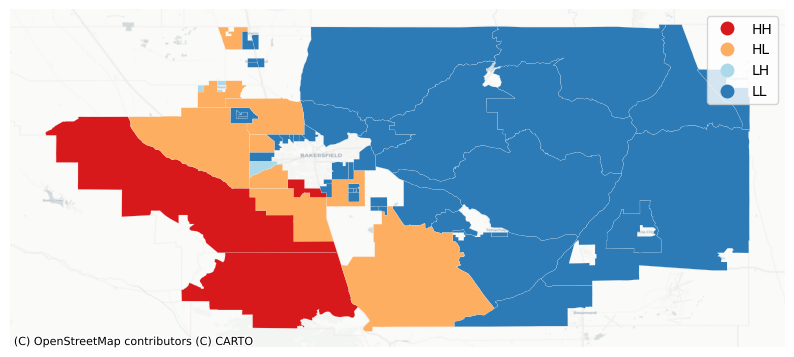

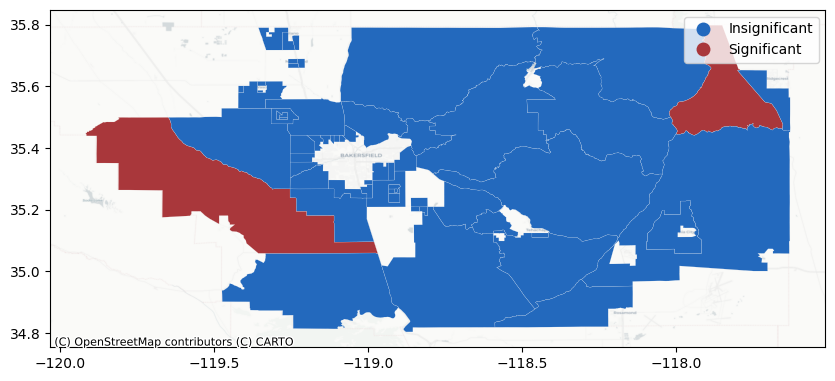

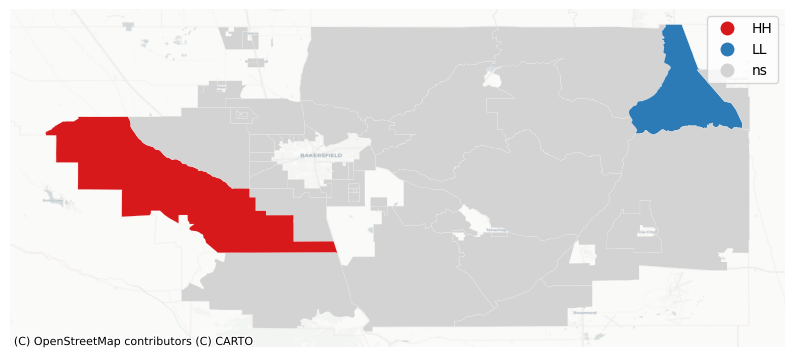

[<Figure size 1000x1000 with 1 Axes>,
 0.18926547249228895,
 0.055,
 (<Figure size 1000x400 with 2 Axes>,
  array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.19', ylabel='Density'>,
         <Axes: title={'center': 'Moran Scatterplot (0.19)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
        dtype=object)),
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>]

In [10]:
#spatial autocorrelation for kern
kern_acstats = autocorr(kern_features_grouped)
kern_acstats

/opt/tljh/user/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  warnings.warn(message)
/opt/tljh/user/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/tljh/user/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/tljh/

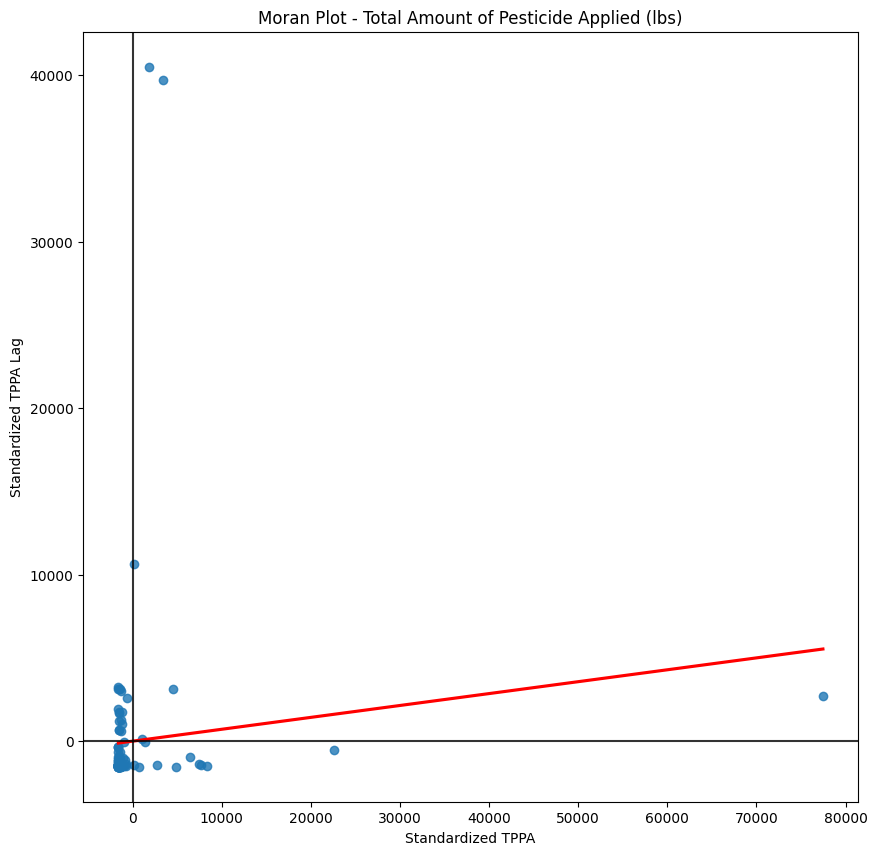

/opt/tljh/user/lib/python3.9/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


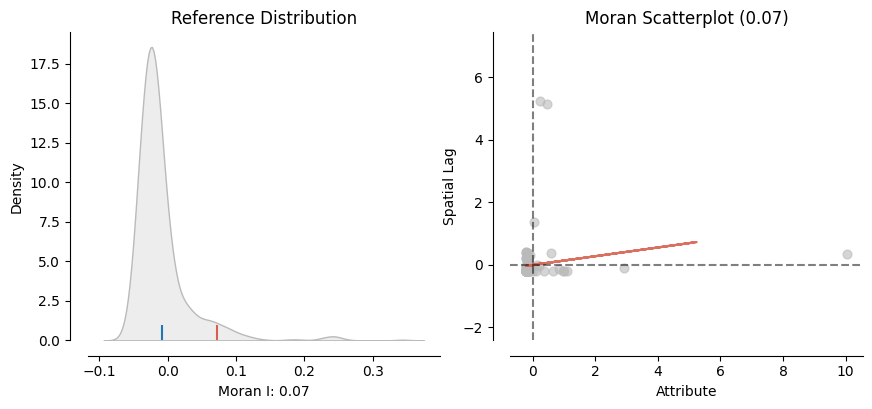

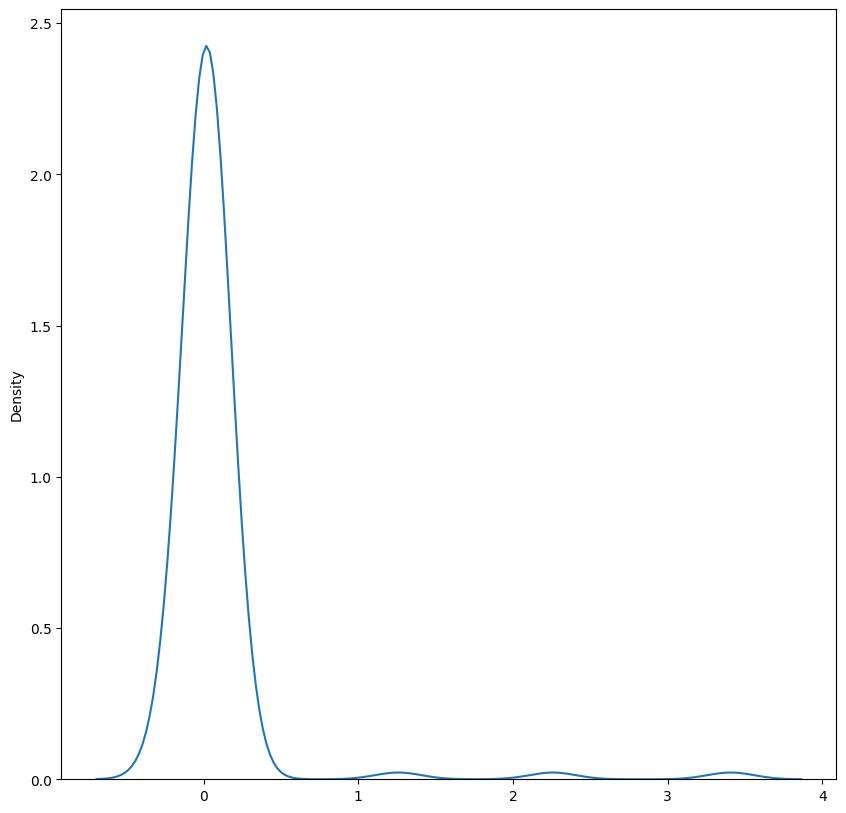

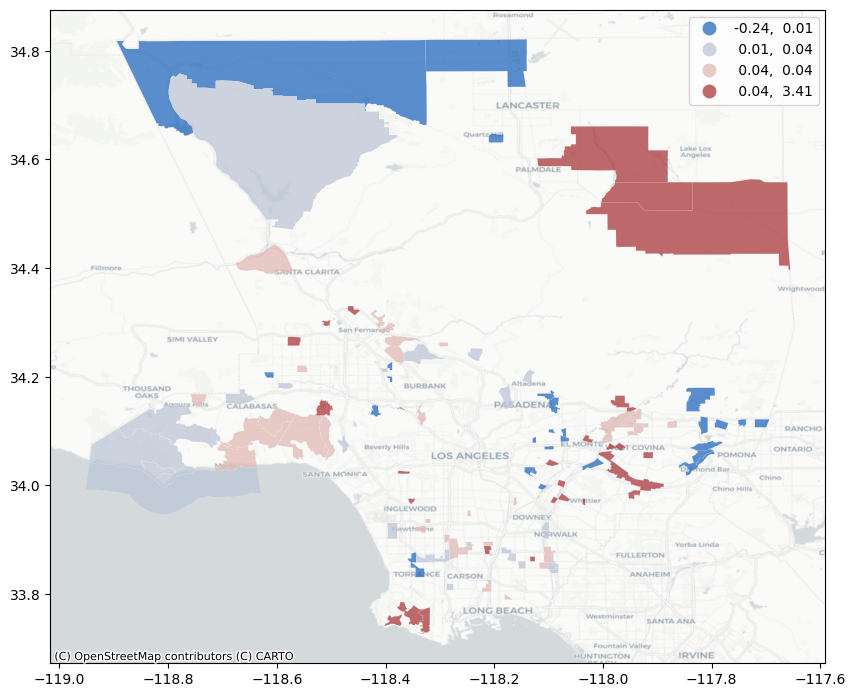

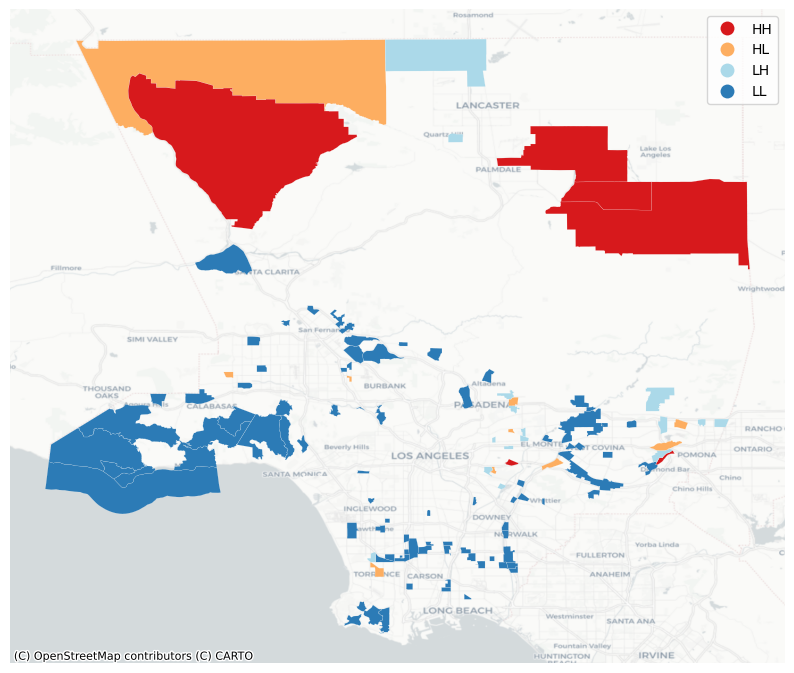

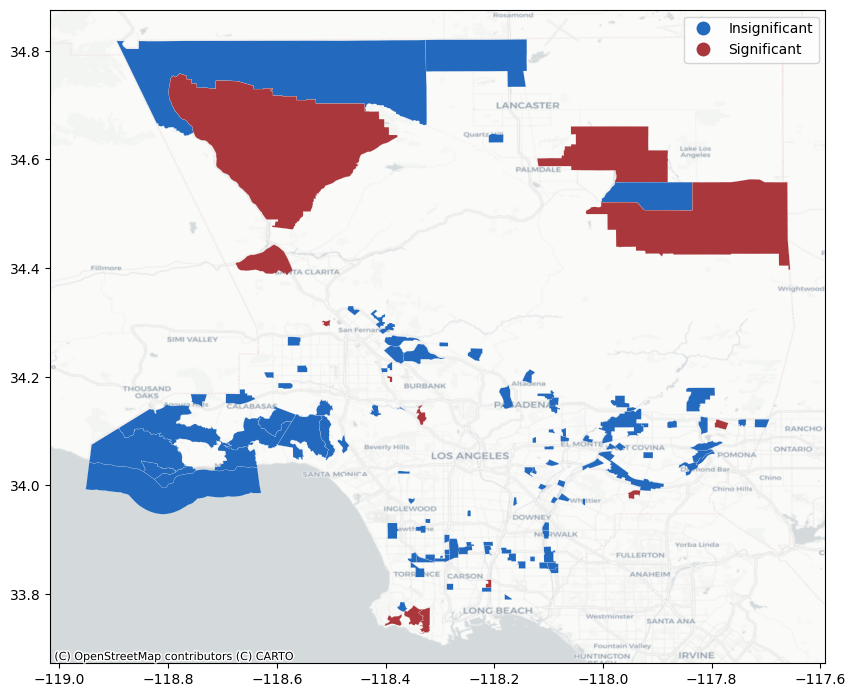

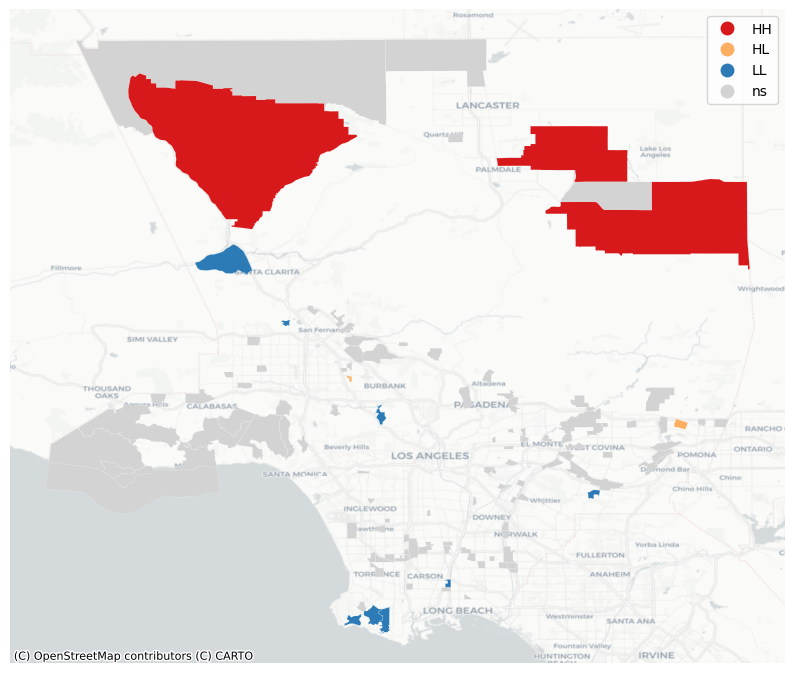

[<Figure size 1000x1000 with 1 Axes>,
 0.07146074299016458,
 0.047,
 (<Figure size 1000x400 with 2 Axes>,
  array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.07', ylabel='Density'>,
         <Axes: title={'center': 'Moran Scatterplot (0.07)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
        dtype=object)),
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>]

In [11]:
#spatial autocorrelation for LA
la_acstats = autocorr(la_features_grouped)
la_acstats

/opt/tljh/user/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/opt/tljh/user/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/tljh/user/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/tljh/

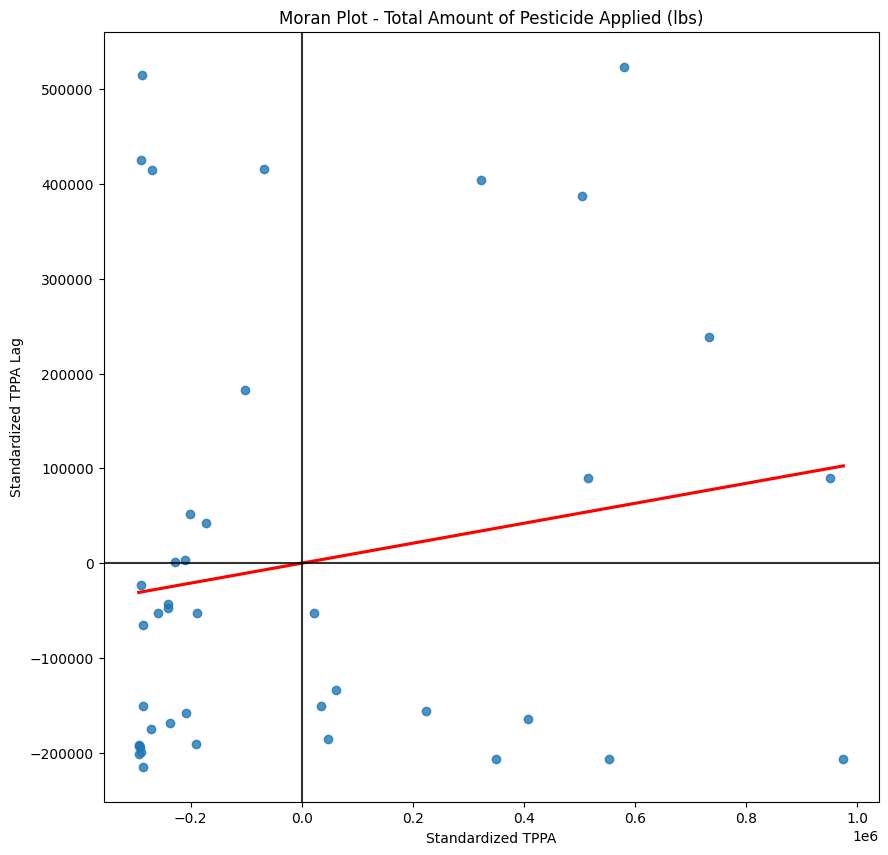

/opt/tljh/user/lib/python3.9/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


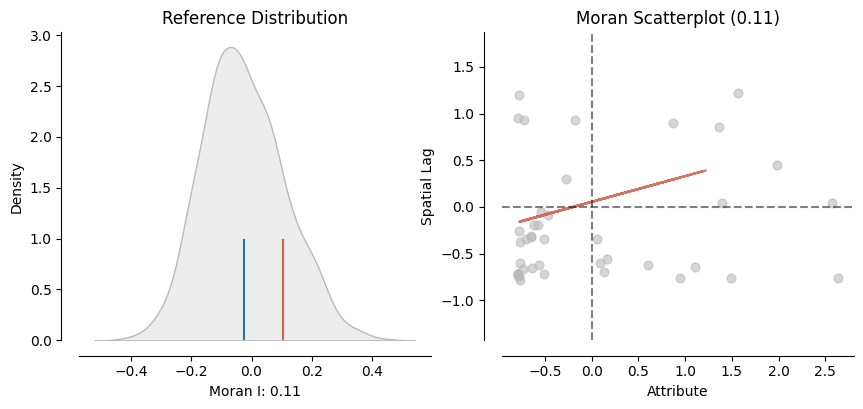

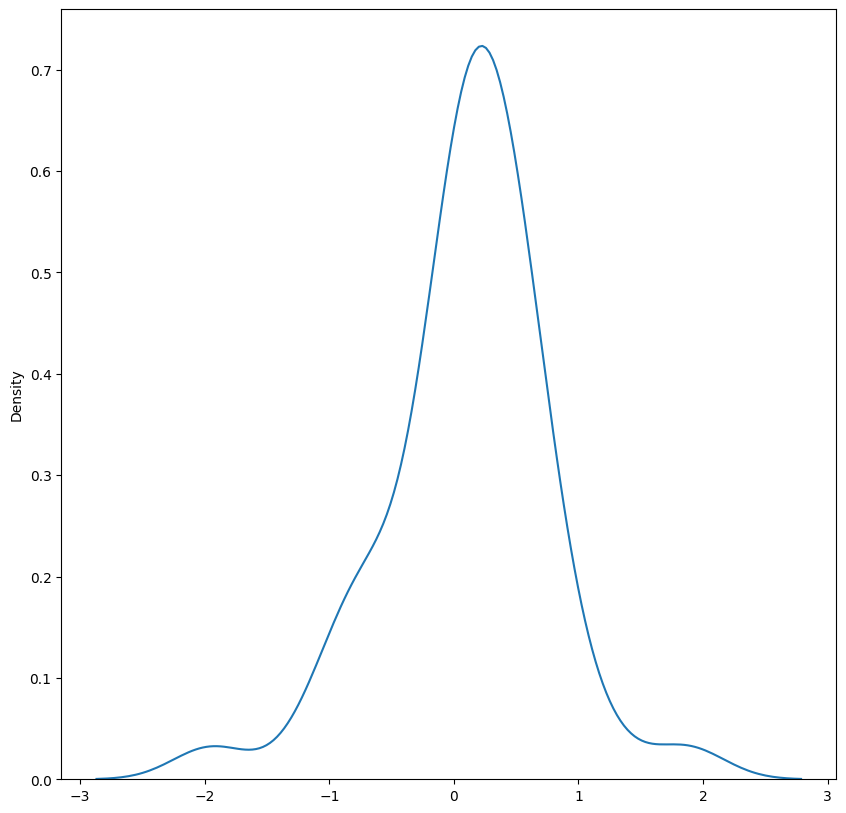

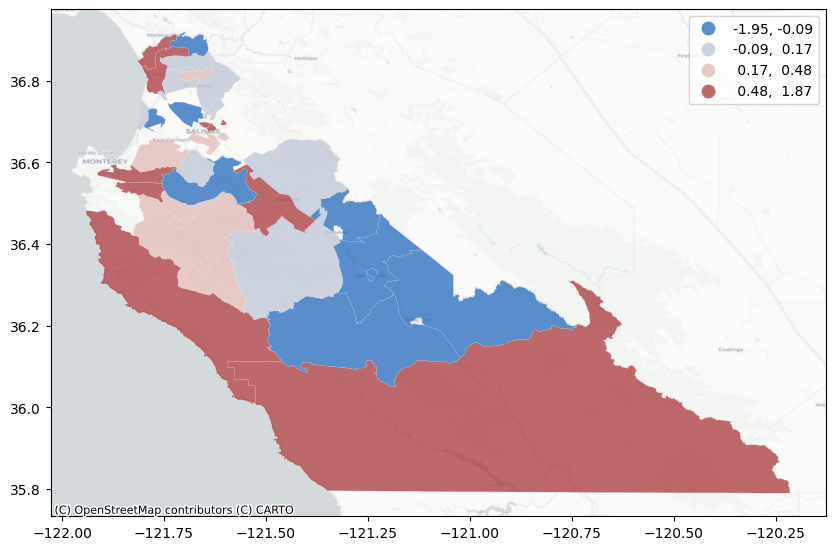

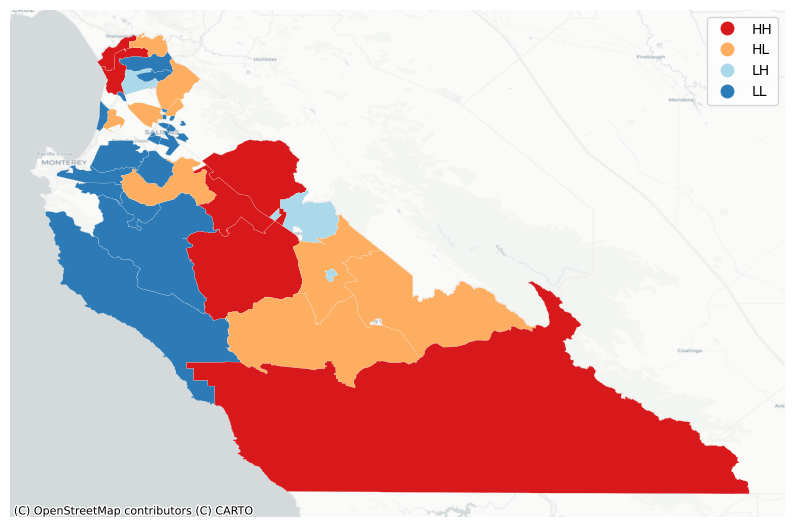

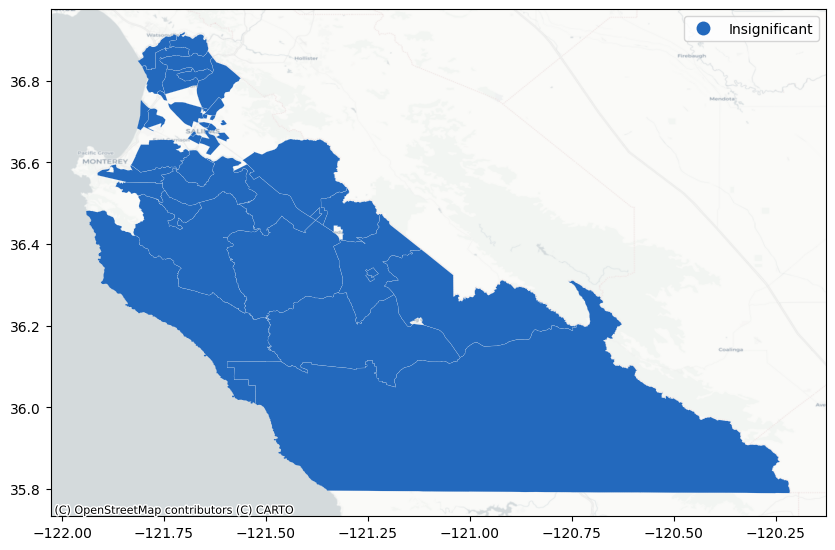

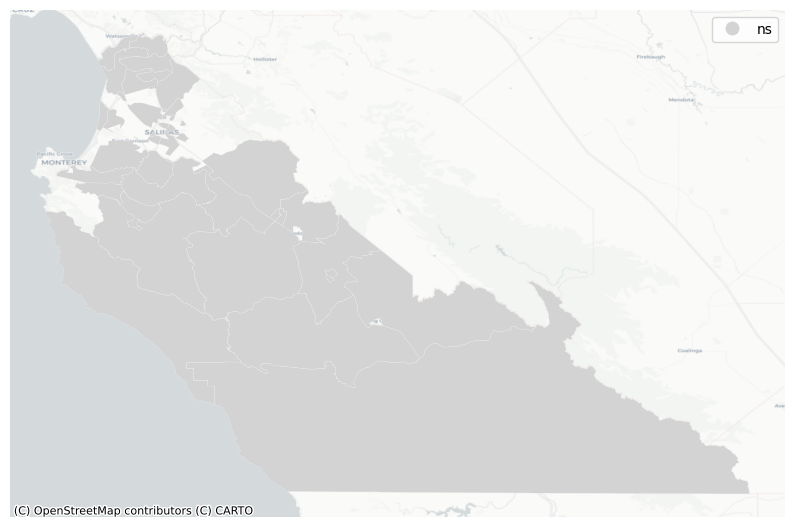

[<Figure size 1000x1000 with 1 Axes>,
 0.10527775543567582,
 0.168,
 (<Figure size 1000x400 with 2 Axes>,
  array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.11', ylabel='Density'>,
         <Axes: title={'center': 'Moran Scatterplot (0.11)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
        dtype=object)),
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>]

In [12]:
#spatial autocorrelation for Monterey
monterey_acstats = autocorr(monterey_features_grouped)
monterey_acstats

/opt/tljh/user/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/tljh/user/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/tljh/user/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

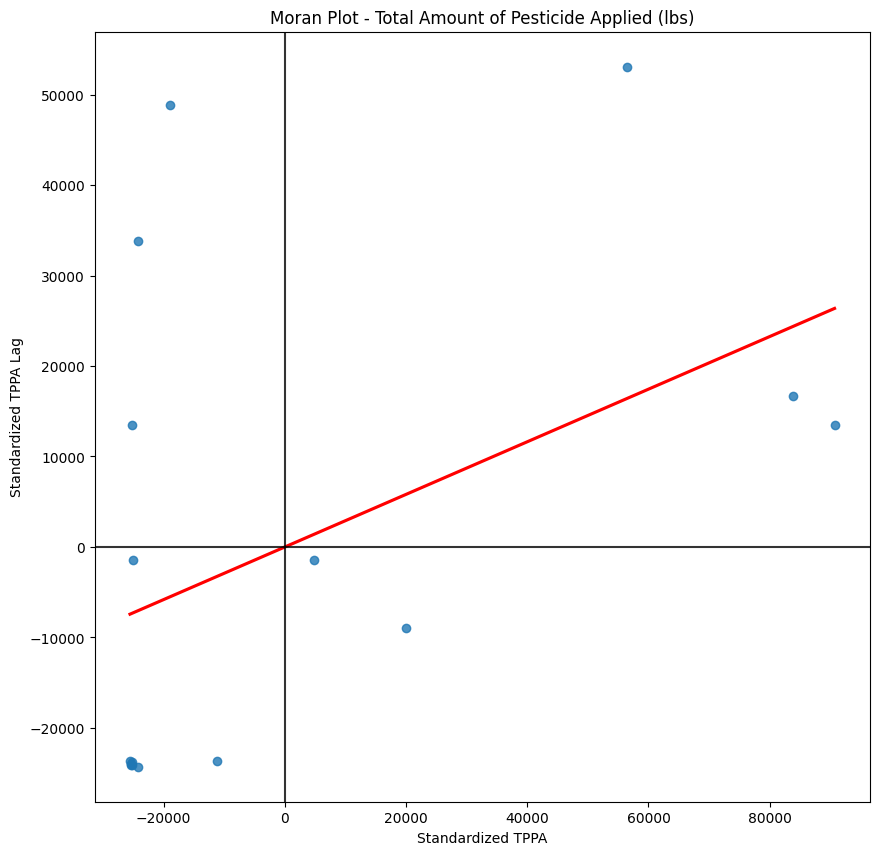

/opt/tljh/user/lib/python3.9/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


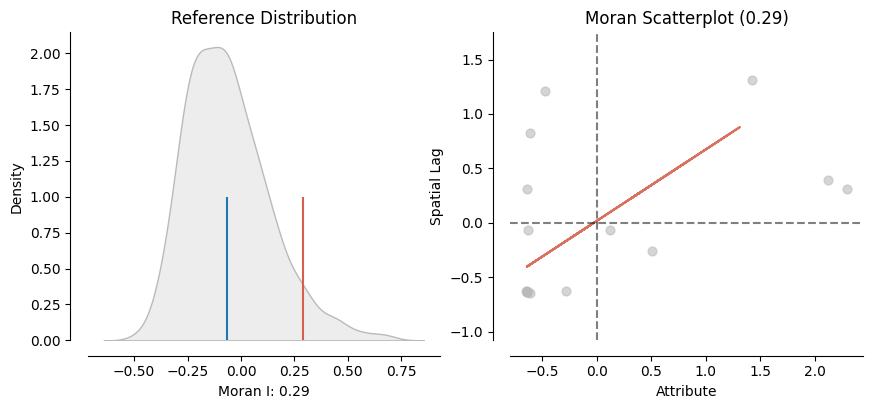

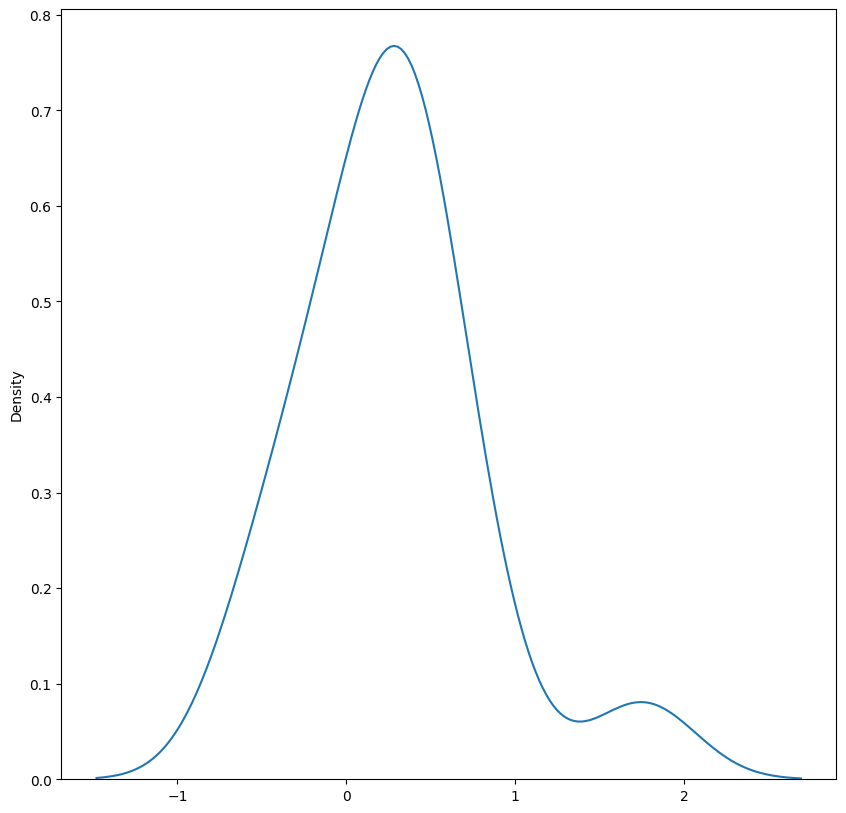

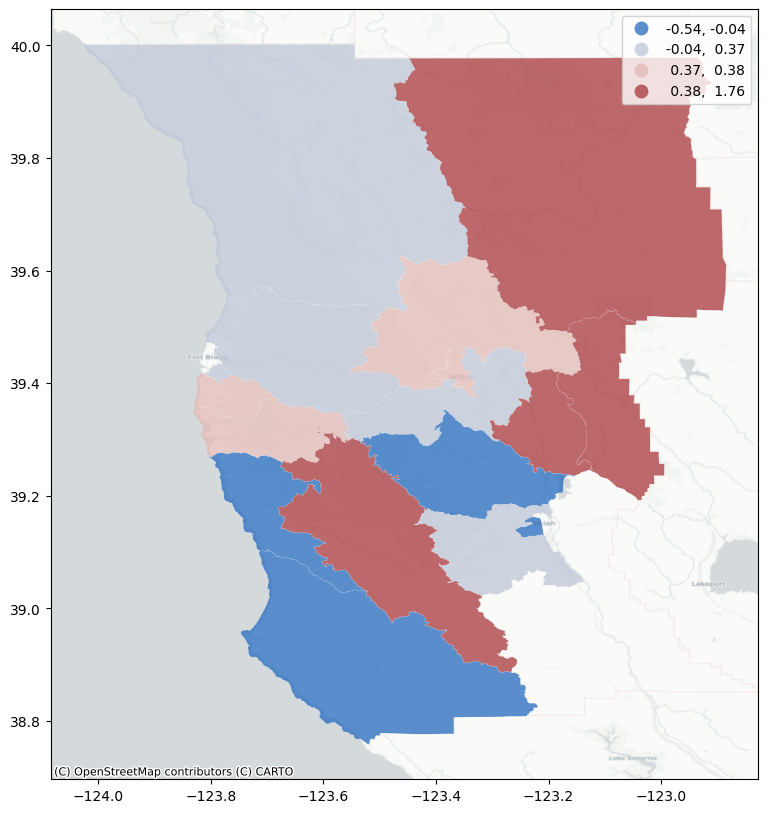

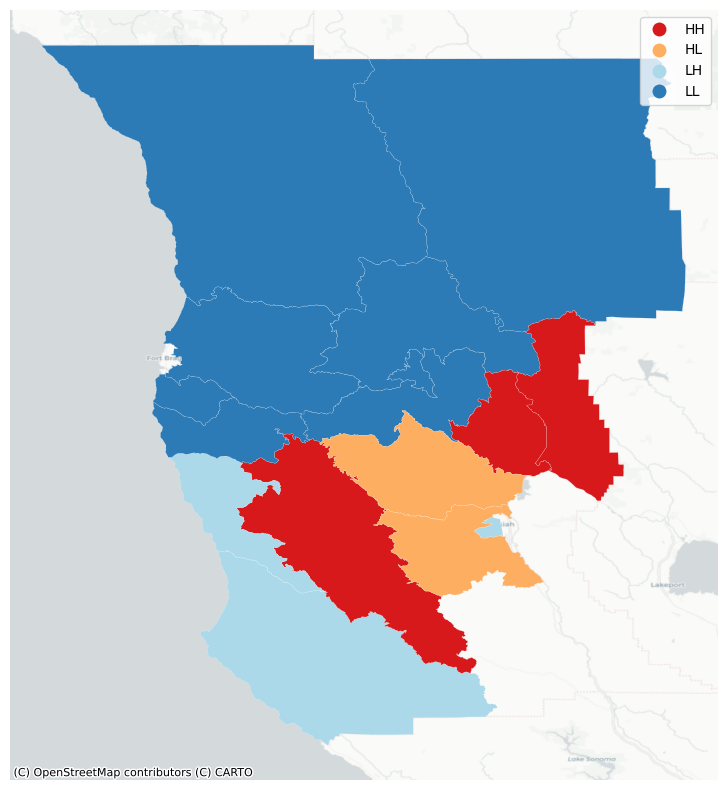

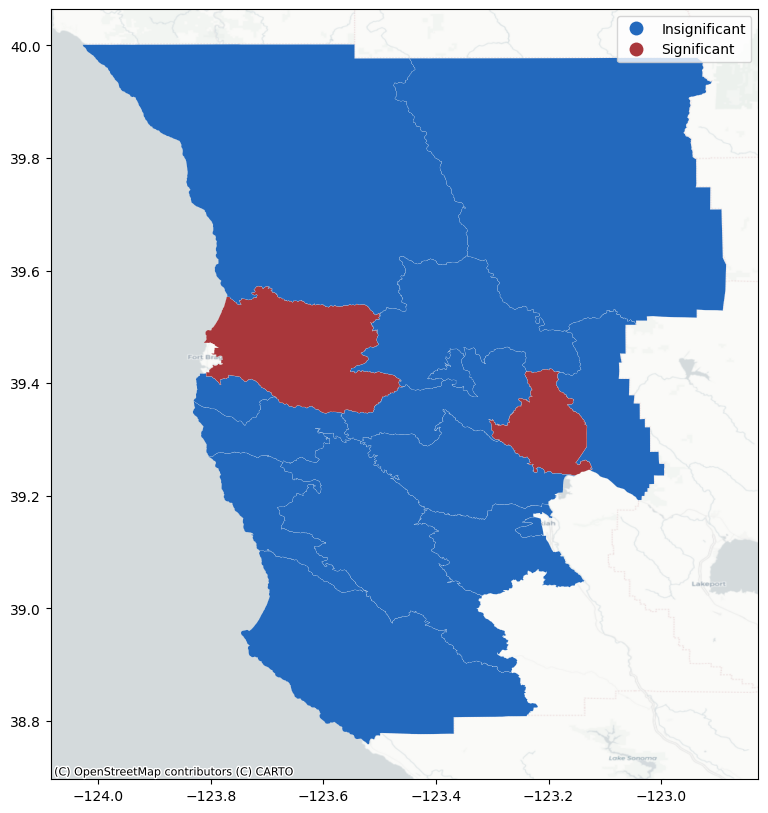

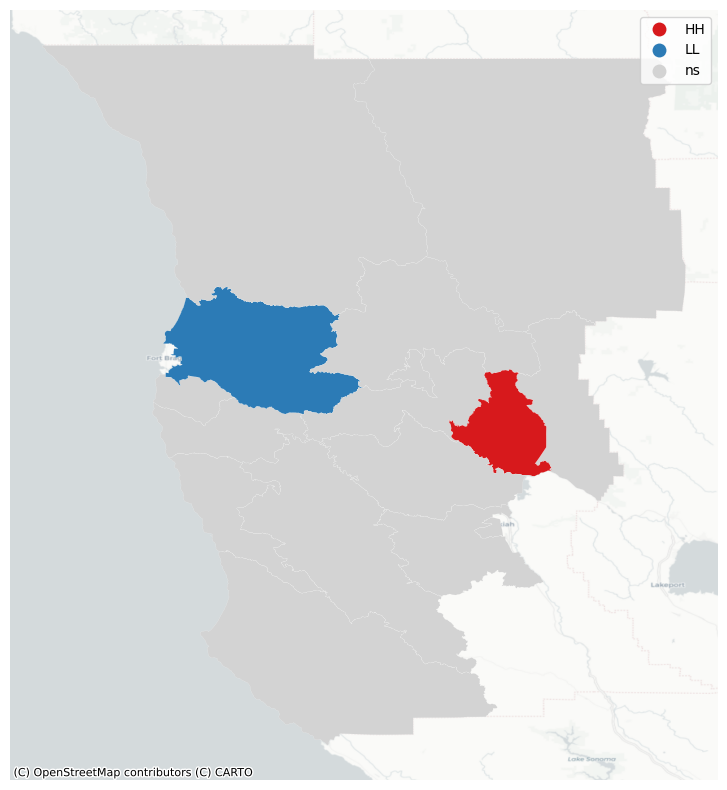

[<Figure size 1000x1000 with 1 Axes>,
 0.29068399577586457,
 0.055,
 (<Figure size 1000x400 with 2 Axes>,
  array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.29', ylabel='Density'>,
         <Axes: title={'center': 'Moran Scatterplot (0.29)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
        dtype=object)),
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>,
 <Figure size 1000x1000 with 1 Axes>]

In [13]:
#spatial autocorrelation for Mendocino
mendocino_acstats = autocorr(mendocino_features_grouped)
mendocino_acstats

# Linear Regression

In [14]:
#function used to update crs
def find_crs_and_area(county_name):
    if county_name == 'MENDOCINO':
        features2_merged['geometry'] = features2_merged['geometry'].to_crs("EPSG:2226")
    elif county_name == 'MONTEREY' or county_name == 'FRESNO':
        features2_merged['geometry'] = features2_merged['geometry'].to_crs("EPSG:2228")
    elif county_name == 'KERN':
        features2_merged['geometry'] = features2_merged['geometry'].to_crs("EPSG:2230")
    elif county_name == 'LOS ANGELES':
        features2_merged['geometry'] = features2_merged['geometry'].to_crs("EPSG:2229")
    else:
        return np.nan

In [15]:
features2 = features.loc[(features['YEAR'] == 2020), ['PU_FIPS', 'POUNDS_PRODUCT_APPLIED','COUNTY_NAME']]
features2 = features2.groupby(['COUNTY_NAME','PU_FIPS'])['POUNDS_PRODUCT_APPLIED'].sum().reset_index()
#features2

In [16]:
features2_merged = places.merge(features2,'inner', left_on='FIPS GEOID',right_on='PU_FIPS')
#features2_merged

In [17]:
# Update geometry crs and extract the area
features2_merged.COUNTY_NAME.apply(find_crs_and_area)
features2_merged['area'] = features2_merged['geometry'].area

In [18]:
# Convert area (meters) to miles squared
features2_merged['area_sq_miles'] = features2_merged['geometry'].area/(3.587*10**8)#convert to square miles
features2_merged.area_sq_miles.sum()

1542.4176772218639

In [19]:
# standardize pounds product applied by the area where product was applied
features2_merged['ppa_std'] = features2_merged['POUNDS_PRODUCT_APPLIED']/features2_merged['area_sq_miles']
#features2_merged['ppa_std_stand'] = (features2_merged['ppa_std'] - features2_merged['ppa_std'].mean())/features2_merged['ppa_std'].std()

In [20]:
# Variable Transformations
features = features2_merged.dropna()
features['ppa_std_log'] = np.log(features[['ppa_std']])
features['ppa_std_sqrt'] = np.sqrt(features[['ppa_std']])
features['demo_other'] = 1 - (features['pct_nh_american_indian_and_alaska_native_alone']+features['pct_nh_asian_alone']+features['pct_nh_native_hawaiian_and_other_pacific_islander_alone']+
                             features['pct_nh_other']+features['pct_nh_two_or_more'])
features

/opt/tljh/user/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/tljh/user/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/tljh/user/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

STATEFP COUNTYFP TRACTFP  FIPS GEOID    NAME             NAMELSAD  MTFCC  \
0        06      029  005509  6029005509   55.09   Census Tract 55.09  G5020   
1        06      029  004605  6029004605   46.05   Census Tract 46.05  G5020   
2        06      029  004304  6029004304   43.04   Census Tract 43.04  G5020   
3        06      029  004703  6029004703   47.03   Census Tract 47.03  G5020   
4        06      029  004704  6029004704   47.04   Census Tract 47.04  G5020   
..      ...      ...     ...         ...     ...                  ...    ...   
331      06      019  007202  6019007202   72.02   Census Tract 72.02  G5020   
332      06      019  005408  6019005408   54.08   Census Tract 54.08  G5020   
333      06      019  005504  6019005504   55.04   Census Tract 55.04  G5020   
334      06      037  300100  6037300100    3001    Census Tract 3001  G5020   
335      06      053  010202  6053010202  102.02  Census Tract 102.02  G5020   

    FUNCSTAT      ALAND   AWATER     INTPTLAT      INTPTLON         FIPS  \
0          S  120534842     5245  +35.5725952  -117.6939426  06029005509   
1          S  479143514  1680457  +35.6698917  -119.1793152  06029004605   
2          S    3947504        0  +35.6086914  -119.3444583  06029004304   
3          S    4941079        0  +35.6669977  -119.2417788  06029004703   
4          S    4407797        0  +35.6814830  -119.2434780  06029004704   
..       ...        ...      ...          ...           ...          ...   
331        S    5344718        0  +36.5082093  -119.5666686  06019007202   
332        S    4957618        0  +36.8188106  -119.7423200  06019005408   
333        S    2520551        0  +36.8885345  -119.7386292  06019005504   
334        S    4591342    18657  +34.2442558  -118.2325716  06037300100   
335        S   40331725   280374  +36.8474336  -121.6842241  06053010202   

    state   tract               geoid            area_name   area_land  \
0      ca    5509  14000US06029005509   Census Tract 55.09   46.538764   
1      ca    4605  14000US06029004605   Census Tract 46.05  184.998355   
2      ca    4304  14000US06029004304   Census Tract 43.04    1.524140   
3      ca    4703  14000US06029004703   Census Tract 47.03    1.907761   
4      ca    4704  14000US06029004704   Census Tract 47.04    1.701860   
..    ...     ...                 ...                  ...         ...   
331    ca    7202  14000US06019007202   Census Tract 72.02    2.063607   
332    ca    5408  14000US06019005408   Census Tract 54.08    1.914147   
333    ca    5504  14000US06019005504   Census Tract 55.04    0.973190   
334    ca  300100  14000US06037300100    Census Tract 3001    1.772727   
335    ca   10202  14000US06053010202  Census Tract 102.02   15.572166   

     total_pop  housing_units  owner_occupied_housing_units  \
0         4335           1991                          1179   
1         3204            910                           736   
2         2542            707                           625   
3         5130           1002                           677   
4         5910           1474                           719   
..         ...            ...                           ...   
331       5682           1849                          1226   
332       2094            367                             0   
333       2889           1063                           836   
334       6662           2168                          1826   
335       4135           1454                           910   

     persons_no_health_insurance  families  \
0                            257      1224   
1                             43       715   
2                            259       606   
3                            208       918   
4                            280      1181   
..                           ...       ...   
331                          465      1191   
332                          175        76   
333                           74       726   
334                     

# Correlation Heatmap

                                         ppa_std  pct_nh_white_alone  \
ppa_std                                 1.000000           -0.218675   
pct_nh_white_alone                     -0.218675            1.000000   
pct_nh_black_or_african_american_alone -0.124280           -0.235314   
pct_hispanic_or_latino                  0.320201           -0.835887   
demo_other                              0.174968            0.057823   
pct_no_health_insurance                 0.207325           -0.449105   
median_household_income                -0.150206            0.476123   
total_pop                               0.053742           -0.335695   
families                               -0.003154           -0.153962   
housing_units                          -0.091016            0.132645   

                                        pct_nh_black_or_african_american_alone  \
ppa_std                                                              -0.124280   
pct_nh_white_alone                         

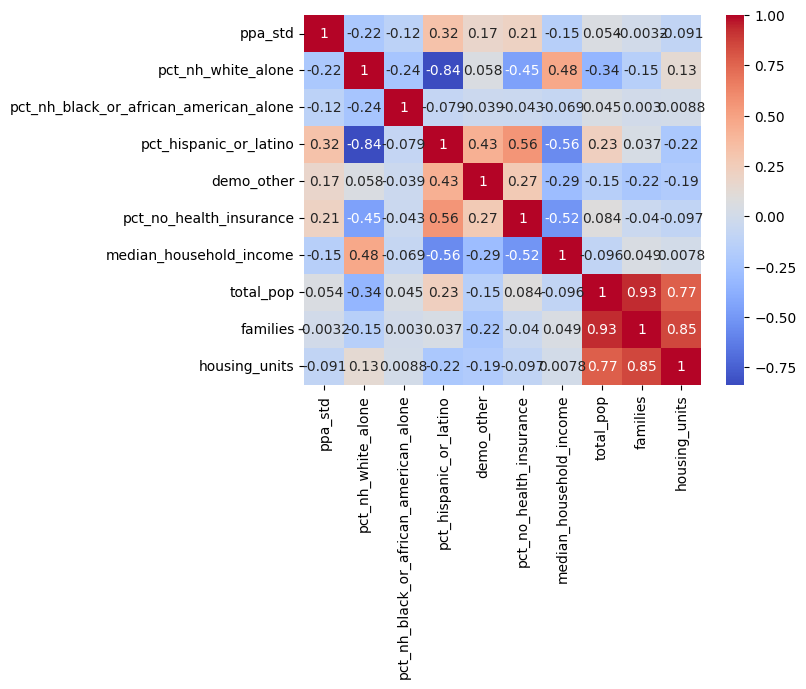

In [21]:
import seaborn as sns

feat = features[['ppa_std','pct_nh_white_alone','pct_nh_black_or_african_american_alone','pct_hispanic_or_latino','demo_other','pct_no_health_insurance','median_household_income','total_pop','families','housing_units']]

# Creating the correlation matrix of the iris dataset
features_corr_matrix = feat.corr()
print(features_corr_matrix)

# Create the heatmap using the `heatmap` function of Seaborn
sns.heatmap(features_corr_matrix, cmap='coolwarm', annot=True)

# Display the heatmap using the `show` method of the `pyplot` module from matplotlib.
plt.show()

# Generalized Linear Model

/tmp/ipykernel_2674028/2813961435.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.drop(features['ppa_std'].idxmax(),inplace=True)


1246331.2889297963


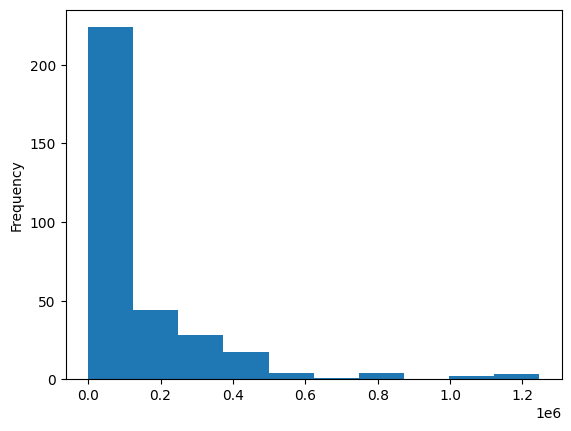

In [22]:
#drop pounds of pesticides applied outlier
#features['ppa_std'].max()
features.drop(features['ppa_std'].idxmax(),inplace=True)
features['ppa_std'].plot.hist()
print(features['ppa_std'].max())

In [23]:
x = features[['pct_nh_white_alone','pct_nh_black_or_african_american_alone','pct_hispanic_or_latino','demo_other','pct_no_health_insurance','median_household_income','total_pop','families','housing_units']]
y = features['ppa_std']

x = sm.add_constant(x)

model = sm.GLM(y, x, family=sm.families.Gamma(link=sm.families.links.log())).fit()#log()#identity()#sm.families.Gamma(link=sm.families.links.log())

print_model = model.summary()
print(print_model)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ppa_std   No. Observations:                  327
Model:                            GLM   Df Residuals:                      318
Model Family:                   Gamma   Df Model:                            8
Link Function:                    log   Scale:                          4.0484
Method:                          IRLS   Log-Likelihood:                -3779.0
Date:                Thu, 27 Jul 2023   Deviance:                       1423.2
Time:                        16:35:56   Pearson chi2:                 1.29e+03
No. Iterations:                    34   Pseudo R-squ. (CS):             0.1882
Covariance Type:            nonrobust                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

/opt/tljh/user/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [24]:
features.to_csv('features_cleaned.csv')